<a href="https://colab.research.google.com/github/yuhe6/Stat-430-Deep-Learning/blob/main/practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install split-folders
import splitfolders
splitfolders.ratio('./drive/MyDrive/dhz/newDogAndCat', output="./drive/MyDrive/dhz/Outputnew", seed=1, ratio=(.7, 0.3))

Copying files: 1600 files [04:10,  6.38 files/s]


In [ ]:
# this is the pre-augmentated dataset
from torchvision import datasets
from torchvision import transforms
traindataset = datasets.ImageFolder(
    root="./drive/MyDrive/dhz/Outputnew/train", 
    transform = transforms.ToTensor())
testdataset = datasets.ImageFolder(
    root="./drive/MyDrive/dhz/Outputnew/val", 
    transform= transforms.ToTensor())
img, label = traindataset[0]
print(img.shape,label)

torch.Size([3, 500, 375]) 0


In [ ]:
from torchvision.transforms.transforms import RandomRotation
from torchvision.transforms.functional_pil import rotate
# augmentation (Problem in this chunk, since the traindataset does not have uniform size as the argumented one.
# I make some changes as the following. The function, train_augmentation is used to flip instead of resizing.)
from torch.utils.data import ConcatDataset
# Augmentation = transforms.Compose([
#     transforms.Resize(size = (256, 256)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(45),
#     transforms.CenterCrop(10),
#     transforms.ColorJitter(brightness=.5, hue=.3),
#     transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
#     transforms.ToTensor()
# ])

Augmentation_Flip = transforms.Compose([
    transforms.Resize(size = (256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

Augmentation_Rotae = transforms.Compose([
    transforms.Resize(size = (256, 256)),
    transforms.RandomRotation(45),
    transforms.ToTensor()
])

Augmentation_Crop = transforms.Compose([
    transforms.CenterCrop(100),
    transforms.Resize(size = (256, 256)),
    transforms.ToTensor()
])

Augmentation_Color = transforms.Compose([
    transforms.Resize(size = (256, 256)),
    transforms.ColorJitter(brightness=.5, hue=.3),
    transforms.ToTensor()
])

Augmentation_Blur = transforms.Compose([
    transforms.Resize(size = (256, 256)),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.ToTensor()
])

Resize_Only = transforms.Compose([
    transforms.Resize(size = (256, 256)),
    transforms.ToTensor()
])

Flip_dataset = datasets.ImageFolder(
    root="./drive/MyDrive/dhz/Outputnew/train", 
    transform = Augmentation_Flip)

Rotae_dataset = datasets.ImageFolder(
    root="./drive/MyDrive/dhz/Outputnew/train", 
    transform = Augmentation_Rotae)

Crop_dataset = datasets.ImageFolder(
    root="./drive/MyDrive/dhz/Outputnew/train", 
    transform = Augmentation_Crop)

Color_dataset = datasets.ImageFolder(
    root="./drive/MyDrive/dhz/Outputnew/train", 
    transform = Augmentation_Color)

Blur_dataset = datasets.ImageFolder(
    root="./drive/MyDrive/dhz/Outputnew/train", 
    transform = Augmentation_Blur)

Train_Dataset = datasets.ImageFolder(
    root="./drive/MyDrive/dhz/Outputnew/train", 
    transform = Resize_Only)

Concat_Flip = ConcatDataset([Train_Dataset, Flip_dataset])
Concat_Rotae = ConcatDataset([Train_Dataset, Rotae_dataset])
Concat_Crop = ConcatDataset([Train_Dataset, Crop_dataset])
Concat_Color = ConcatDataset([Train_Dataset, Color_dataset])
Concat_Blur = ConcatDataset([Train_Dataset, Blur_dataset])

Test_Dataset = datasets.ImageFolder(
    root="./drive/MyDrive/dhz/Outputnew/val", 
    transform = Resize_Only)

In [ ]:
import torch
import torch.nn as nn
# Load Augmentated Train Data into a DataLoader
Flip_Train_Loader = torch.utils.data.DataLoader(
  dataset = Concat_Flip,
  batch_size = 8,
  shuffle = True,
  )

Rotate_Train_Loader = torch.utils.data.DataLoader(
  dataset = Concat_Rotae,
  batch_size = 8,
  shuffle = True,
  )

Crop_Train_Loader = torch.utils.data.DataLoader(
  dataset = Concat_Crop,
  batch_size = 8,
  shuffle = True,
  )

Color_Train_Loader = torch.utils.data.DataLoader(
  dataset = Concat_Color,
  batch_size = 8,
  shuffle = True,
  )

Blur_Train_Loader = torch.utils.data.DataLoader(
  dataset = Concat_Blur,
  batch_size = 8,
  shuffle = True,
  )

# Load Orignal Train Data into a DataLoader
Orignal_Train_Loader = torch.utils.data.DataLoader(
  dataset = Train_Dataset, 
  batch_size = 8,  
  shuffle = True  
)

# Load Test Data into a DataLoader
Animal_test_loader = torch.utils.data.DataLoader(
  dataset = Test_Dataset, 
  batch_size = 8,  # Make sure this matches with the training dimension
  shuffle = False  # Avoid shuffling.
)

In [ ]:
for images, labels in Flip_Train_Loader:  
  print(f'Train Image Batch Shape: {images.shape}')
  print(f'Train Image Label Shape: {labels.shape}')
  # Just get a single iteration, no need to check multiple values
  break

Train Image Batch Shape: torch.Size([8, 3, 256, 256])
Train Image Label Shape: torch.Size([8])


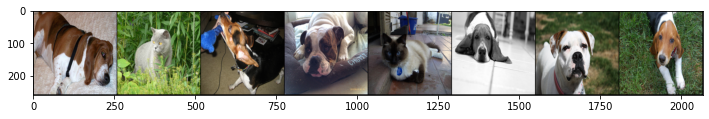

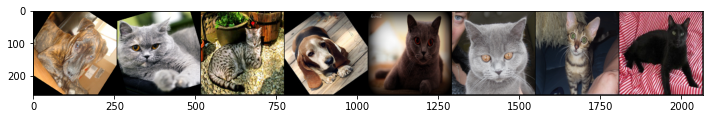

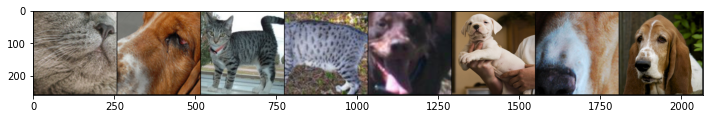

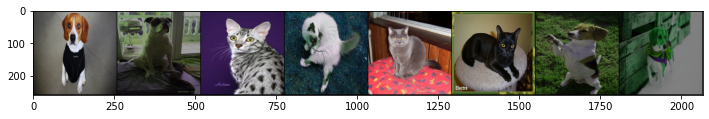

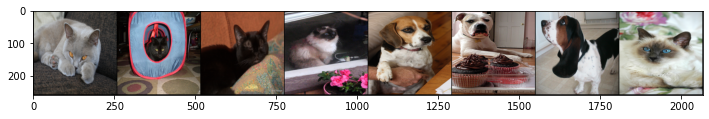

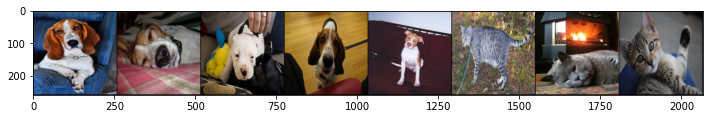

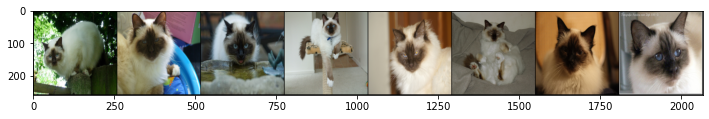

In [ ]:
# Construct a graph showing the data transformations
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
def display_pic(x):
    for images, labels in x:
        fig,ax = plt.subplots(figsize = (12,12))
        ax.imshow(make_grid(images,nrow=8).permute(1,2,0))
        break

display_pic(Flip_Train_Loader)
display_pic(Rotate_Train_Loader)
display_pic(Crop_Train_Loader)
display_pic(Color_Train_Loader)
display_pic(Blur_Train_Loader)
display_pic(Orignal_Train_Loader)
display_pic(Animal_test_loader)

# Model 1


In [ ]:
import torch.nn.functional as F 
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(1)
class Net(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        # we use the maxpool multiple times, but define it once
        self.pool = nn.MaxPool2d(2,2)
        # in_channels = 6 because self.conv1 output 6 channel
        self.conv2 = nn.Conv2d(16, 32, 2) 
        # 5*5 comes from the dimension of the last convnet layer
        self.norm = nn.BatchNorm2d(16)
        self.dropout1 = nn.Dropout2d(0.2)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(32*63*63, 1024) 
        self.fc2 = nn.Linear(1024, 64)
        self.fc3 = nn.Linear(64, 2)
        
    def forward(self, x): 
        x = F.relu(self.conv1(x))
        x = self.norm(x)
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)
        x = x.view(-1, 32*63*63)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)  # no activation on final layer 
        return x

torch.manual_seed(1)
Net_Flip = Net()
Net_Rotate = Net()
Net_Crop = Net()
Net_Color = Net()
Net_Blur = Net()
Net_Orignal = Net()

In [ ]:
# move the model to GPU for speed if available
if torch.cuda.is_available():
  Net_Flip.to('cuda')
  Net_Rotate.to('cuda')
  Net_Crop.to('cuda')
  Net_Color.to('cuda')
  Net_Blur.to('cuda')
  Net_Orignal.to('cuda')

## Flip

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Net_Flip.parameters(), lr=0.01, momentum=0.8, weight_decay = 0.02)

0 10 0.7901395678520202
0 20 0.7144916415214538
0 30 0.681602132320404
0 40 0.67372345328331
0 50 0.6477900862693786
0 60 0.6651592254638672
0 70 0.7091827511787414
0 80 0.6915299534797669
0 90 0.6425017416477203
0 100 0.6507647275924683
0 110 0.6220009177923203
0 120 0.6427785724401474
0 130 0.6625847280025482
0 140 0.6337855190038681
0 150 0.7421496152877808
0 160 0.6906229317188263
0 170 0.6569990992546082
0 180 0.5692435175180435
0 190 0.6231514275074005
0 200 0.670977583527565
0 210 0.611464774608612
0 220 0.6833926558494567
0 230 0.642757648229599
0 240 0.5934269577264786
0 250 0.4399115800857544
0 260 0.8151584327220917
0 270 0.6520367980003356
0 280 0.6100088268518448
1 10 0.5982243567705154
1 20 0.575323086977005
1 30 0.5387856155633927
1 40 0.6574834913015366
1 50 0.5921335399150849
1 60 0.5441039592027664
1 70 0.6603191524744034
1 80 0.6213721483945847
1 90 0.5816146612167359
1 100 0.654050150513649
1 110 0.6051395058631897
1 120 0.5568444281816483
1 130 0.45171999037265775


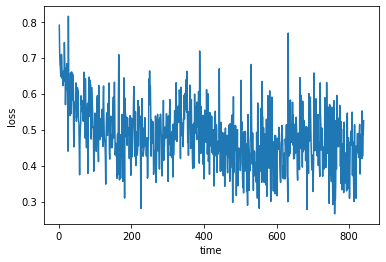

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
running_loss = 0 
printfreq = 10
l = []
t = []
k = 0
test_accu = []
train_accu = []
torch.manual_seed(1)
for epoch in range(30):
    for i, data in enumerate(Flip_Train_Loader):
        inputs, labels = data
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        optimizer.zero_grad()
        outputs = Net_Flip(inputs)  # forward pass 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % printfreq == printfreq-1:  
            print(epoch, i+1, running_loss / printfreq)
            k = k + 1
            l.append(running_loss / printfreq)
            t.append(k)
            running_loss = 0 

    total_test = 0  # keeps track of how many images we have processed 
    correct_test = 0  # keeps track of how many correct images our net predicts
    fname = './drive/MyDrive/dhz/images/Net_Flip' + str(epoch) + '.pth'
    torch.save(Net_Flip.state_dict(), fname)
    loaded_dict = torch.load(fname)
    Net_Flip.load_state_dict(loaded_dict)
    with torch.no_grad():
      for i, data in enumerate(Animal_test_loader): 
        images, labels = data
        images = images.to('cuda')
        labels = labels.to('cuda')
        outputs = Net_Flip(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size()[0]
        correct_test += (predicted == labels).sum().item()
        
    test_accu.append(correct_test/total_test)

    total_train = 0  # keeps track of how many images we have processed 
    correct_train = 0  # keeps track of how many correct images our net predicts
    with torch.no_grad():
      for i, data in enumerate(Flip_Train_Loader): 
        images, labels = data
        images = images.to('cuda')
        labels = labels.to('cuda')
        outputs = Net_Flip(images)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size()[0]
        correct_train += (predicted == labels).sum().item()
        
    train_accu.append(correct_train/total_train)
# plotting
l = np.array(l)
t = np.array(t)
plt.plot(t, l)
plt.xlabel("time")
plt.ylabel("loss")
plt.show()

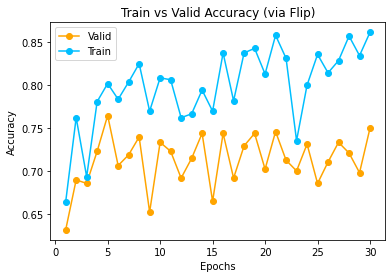

In [ ]:
epoch = range(1, len(test_accu) + 1)
test_accu_flip = test_accu
train_accu_flip = train_accu
plt.title("Train vs Valid Accuracy (via Flip)")
plt.plot(epoch, test_accu_flip, marker='o', color='orange', label='Valid')
plt.plot(epoch, train_accu_flip, marker='o', color='deepskyblue', label='Train')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

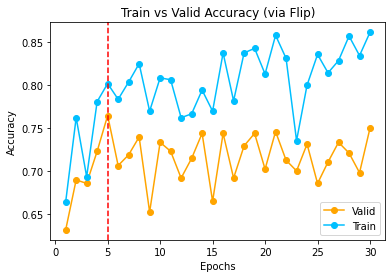

In [ ]:
plt.title("Train vs Valid Accuracy (via Flip)")
plt.plot(epoch, test_accu_flip, marker='o', color='orange', label='Valid')
plt.plot(epoch, train_accu_flip, marker='o', color='deepskyblue', label='Train')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.axvline(x=test_accu_flip.index(max(test_accu_flip))+1, color='r', linestyle='--')
plt.show()

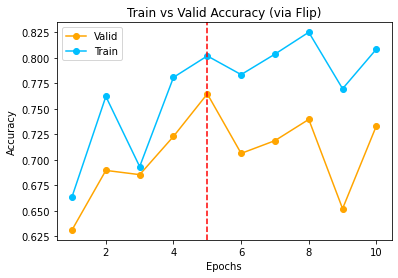

In [ ]:
plt.title("Train vs Valid Accuracy (via Flip)")
plt.plot(epoch[0:10], test_accu_flip[0:10], marker='o', color='orange', label='Valid')
plt.plot(epoch[0:10], train_accu_flip[0:10], marker='o', color='deepskyblue', label='Train')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.axvline(x=test_accu_flip.index(max(test_accu_flip[0:10]))+1, color='r', linestyle='--')
plt.show()

In [ ]:
print(f'Train accuracy iteration: {train_accu_flip}')
print(f'Test accuracy iteration: {test_accu_flip}')

Train accuracy iteration: [0.6638392857142857, 0.7620535714285714, 0.6933035714285715, 0.7808035714285714, 0.8017857142857143, 0.7834821428571429, 0.8035714285714286, 0.825, 0.7696428571428572, 0.8084821428571428, 0.80625, 0.7620535714285714, 0.7665178571428571, 0.7941964285714286, 0.7696428571428572, 0.8375, 0.7816964285714286, 0.8375, 0.8428571428571429, 0.8129464285714286, 0.8580357142857142, 0.83125, 0.7352678571428571, 0.8, 0.8357142857142857, 0.8142857142857143, 0.8285714285714286, 0.8571428571428571, 0.834375, 0.8616071428571429]
Test accuracy iteration: [0.63125, 0.6895833333333333, 0.6854166666666667, 0.7229166666666667, 0.7645833333333333, 0.70625, 0.71875, 0.7395833333333334, 0.6520833333333333, 0.7333333333333333, 0.7229166666666667, 0.6916666666666667, 0.7145833333333333, 0.74375, 0.6645833333333333, 0.74375, 0.6916666666666667, 0.7291666666666666, 0.74375, 0.7020833333333333, 0.7458333333333333, 0.7125, 0.7, 0.73125, 0.6854166666666667, 0.7104166666666667, 0.7333333333333

## Rotate

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Net_Rotate.parameters(), lr=0.01, momentum=0.8, weight_decay = 0.02)

0 10 0.8940943807363511
0 20 0.718947035074234
0 30 0.7022632598876953
0 40 0.7084794223308564
0 50 0.6981102049350738
0 60 0.6934329688549041
0 70 0.69920614361763
0 80 0.6971140146255493
0 90 0.6979315459728241
0 100 0.6989440858364105
0 110 0.6899652659893036
0 120 0.6974146962165833
0 130 0.6871161997318268
0 140 0.6912761390209198
0 150 0.7008414924144745
0 160 0.6976725995540619
0 170 0.6869319260120392
0 180 0.6825706541538239
0 190 0.6875847101211547
0 200 0.6837380588054657
0 210 0.676876699924469
0 220 0.6691240131855011
0 230 0.6989679992198944
0 240 0.6453540563583374
0 250 0.6238347172737122
0 260 0.7124826073646545
0 270 0.6681163847446442
0 280 0.6618946373462677
1 10 0.5630638301372528
1 20 0.5886995196342468
1 30 0.6342342257499695
1 40 0.6684352606534958
1 50 0.5972897946834564
1 60 0.553396937251091
1 70 0.6633689641952515
1 80 0.5897805869579316
1 90 0.65502327978611
1 100 0.6233792841434479
1 110 0.6278087079524994
1 120 0.6300505936145783
1 130 0.6416605293750763


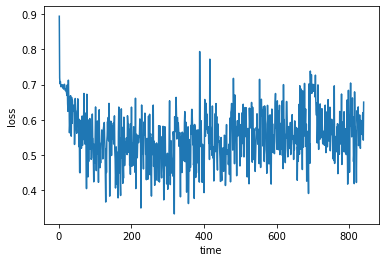

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
running_loss = 0 
printfreq = 10
l = []
t = []
k = 0
test_accu = []
train_accu = []
torch.manual_seed(1)
for epoch in range(30):
    for i, data in enumerate(Rotate_Train_Loader):
        inputs, labels = data
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        optimizer.zero_grad()
        outputs = Net_Rotate(inputs)  # forward pass 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % printfreq == printfreq-1:  
            print(epoch, i+1, running_loss / printfreq)
            k = k + 1
            l.append(running_loss / printfreq)
            t.append(k)
            running_loss = 0 

    total_test = 0  # keeps track of how many images we have processed 
    correct_test = 0  # keeps track of how many correct images our net predicts
    fname = './drive/MyDrive/dhz/images/Net_Rotate' + str(epoch) + '.pth'
    torch.save(Net_Rotate.state_dict(), fname)
    loaded_dict = torch.load(fname)
    Net_Rotate.load_state_dict(loaded_dict)
    with torch.no_grad():
      for i, data in enumerate(Animal_test_loader): 
        images, labels = data
        images = images.to('cuda')
        labels = labels.to('cuda')
        outputs = Net_Rotate(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size()[0]
        correct_test += (predicted == labels).sum().item()
        
    test_accu.append(correct_test/total_test)

    total_train = 0  # keeps track of how many images we have processed 
    correct_train = 0  # keeps track of how many correct images our net predicts
    with torch.no_grad():
      for i, data in enumerate(Rotate_Train_Loader): 
        images, labels = data
        images = images.to('cuda')
        labels = labels.to('cuda')
        outputs = Net_Rotate(images)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size()[0]
        correct_train += (predicted == labels).sum().item()
        
    train_accu.append(correct_train/total_train)
# plotting
l = np.array(l)
t = np.array(t)
plt.plot(t, l)
plt.xlabel("time")
plt.ylabel("loss")
plt.show()

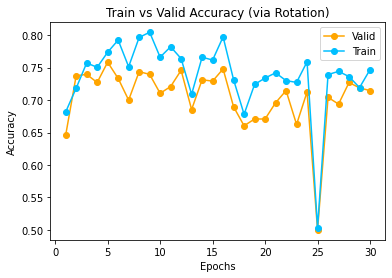

In [ ]:
epoch = range(1, len(test_accu) + 1)
test_accu_rotate = test_accu
train_accu_rotate = train_accu
plt.title("Train vs Valid Accuracy (via Rotation)")
plt.plot(epoch, test_accu_rotate, marker='o', color='orange', label='Valid')
plt.plot(epoch, train_accu_rotate, marker='o', color='deepskyblue', label='Train')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

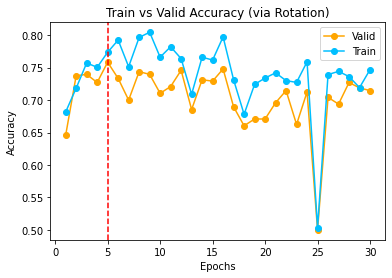

In [ ]:
plt.title("Train vs Valid Accuracy (via Rotation)")
plt.plot(epoch, test_accu_rotate, marker='o', color='orange', label='Valid')
plt.plot(epoch, train_accu_rotate, marker='o', color='deepskyblue', label='Train')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.axvline(x=test_accu_rotate.index(max(test_accu_rotate))+1, color='r', linestyle='--')
plt.show()

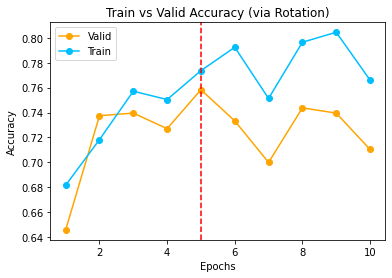

In [ ]:
plt.title("Train vs Valid Accuracy (via Rotation)")
plt.plot(epoch[0:10], test_accu_rotate[0:10], marker='o', color='orange', label='Valid')
plt.plot(epoch[0:10], train_accu_rotate[0:10], marker='o', color='deepskyblue', label='Train')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.axvline(x=test_accu_rotate.index(max(test_accu_rotate[0:10]))+1, color='r', linestyle='--')
plt.show()

In [ ]:
print(f'Train accuracy iteration: {train_accu_rotate}')
print(f'Test accuracy iteration: {test_accu_rotate}')

Train accuracy iteration: [0.6816964285714285, 0.7183035714285714, 0.7571428571428571, 0.7504464285714286, 0.7736607142857143, 0.7924107142857143, 0.7513392857142858, 0.7964285714285714, 0.8044642857142857, 0.7660714285714286, 0.7821428571428571, 0.7638392857142857, 0.7089285714285715, 0.7660714285714286, 0.7616071428571428, 0.7973214285714286, 0.73125, 0.678125, 0.7241071428571428, 0.7339285714285714, 0.7419642857142857, 0.7299107142857143, 0.7272321428571429, 0.7589285714285714, 0.503125, 0.7392857142857143, 0.7441964285714285, 0.7361607142857143, 0.7191964285714286, 0.746875]
Test accuracy iteration: [0.6458333333333334, 0.7375, 0.7395833333333334, 0.7270833333333333, 0.7583333333333333, 0.7333333333333333, 0.7, 0.74375, 0.7395833333333334, 0.7104166666666667, 0.7208333333333333, 0.7458333333333333, 0.6854166666666667, 0.73125, 0.7291666666666666, 0.7479166666666667, 0.6895833333333333, 0.6604166666666667, 0.6708333333333333, 0.6708333333333333, 0.6958333333333333, 0.714583333333333

## Crop

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Net_Crop.parameters(), lr=0.01, momentum=0.8, weight_decay = 0.02)

0 10 0.827864271402359
0 20 0.6970980942249299
0 30 0.6921197295188903
0 40 0.6934837579727173
0 50 0.6856455862522125
0 60 0.6829225242137908
0 70 0.7090177893638611
0 80 0.6996547043323517
0 90 0.6844822764396667
0 100 0.6632509589195251
0 110 0.6471794426441193
0 120 0.7076742887496948
0 130 0.6624254763126374
0 140 0.6948689222335815
0 150 0.6835071742534637
0 160 0.6817533314228058
0 170 0.6244520604610443
0 180 0.706437212228775
0 190 0.5926926255226135
0 200 0.7127898812294007
0 210 0.6944566369056702
0 220 0.6728277862071991
0 230 0.6362858295440674
0 240 0.5992286443710327
0 250 0.6179761052131653
0 260 0.697747004032135
0 270 0.6619124829769134
0 280 0.6588467121124267
1 10 0.635304844379425
1 20 0.7041412651538849
1 30 0.6827412486076355
1 40 0.6009874939918518
1 50 0.554266506433487
1 60 0.6887319326400757
1 70 0.6137557983398437
1 80 0.6656024992465973
1 90 0.6503503322601318
1 100 0.6274255961179733
1 110 0.5807749807834626
1 120 0.5715352863073349
1 130 0.621212357282638

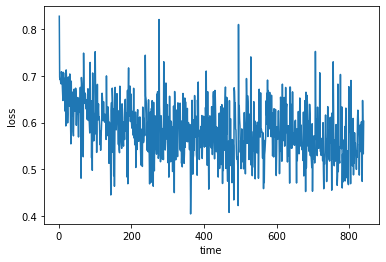

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
running_loss = 0 
printfreq = 10
l = []
t = []
k = 0
test_accu = []
train_accu = []
torch.manual_seed(1)
for epoch in range(30):
    for i, data in enumerate(Crop_Train_Loader):
        inputs, labels = data
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        optimizer.zero_grad()
        outputs = Net_Crop(inputs)  # forward pass 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % printfreq == printfreq-1:  
            print(epoch, i+1, running_loss / printfreq)
            k = k + 1
            l.append(running_loss / printfreq)
            t.append(k)
            running_loss = 0 

    total_test = 0  # keeps track of how many images we have processed 
    correct_test = 0  # keeps track of how many correct images our net predicts
    fname = './drive/MyDrive/dhz/images/Net_Crop' + str(epoch) + '.pth'
    torch.save(Net_Crop.state_dict(), fname)
    loaded_dict = torch.load(fname)
    Net_Crop.load_state_dict(loaded_dict)
    with torch.no_grad():
      for i, data in enumerate(Animal_test_loader): 
        images, labels = data
        images = images.to('cuda')
        labels = labels.to('cuda')
        outputs = Net_Crop(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size()[0]
        correct_test += (predicted == labels).sum().item()
        
    test_accu.append(correct_test/total_test)

    total_train = 0  # keeps track of how many images we have processed 
    correct_train = 0  # keeps track of how many correct images our net predicts
    with torch.no_grad():
      for i, data in enumerate(Crop_Train_Loader): 
        images, labels = data
        images = images.to('cuda')
        labels = labels.to('cuda')
        outputs = Net_Crop(images)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size()[0]
        correct_train += (predicted == labels).sum().item()
        
    train_accu.append(correct_train/total_train)
# plotting
l = np.array(l)
t = np.array(t)
plt.plot(t, l)
plt.xlabel("time")
plt.ylabel("loss")
plt.show()

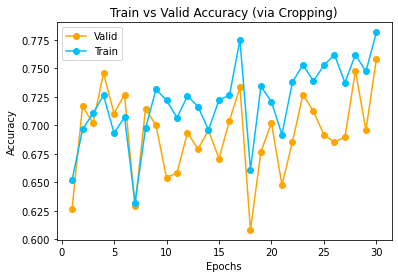

In [ ]:
epoch = range(1, len(test_accu) + 1)
test_accu_crop = test_accu
train_accu_crop = train_accu
plt.title("Train vs Valid Accuracy (via Cropping)")
plt.plot(epoch, test_accu_crop, marker='o', color='orange', label='Valid')
plt.plot(epoch, train_accu_crop, marker='o', color='deepskyblue', label='Train')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

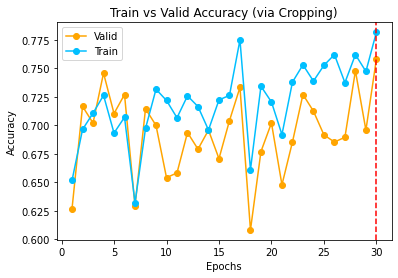

In [ ]:
plt.title("Train vs Valid Accuracy (via Cropping)")
plt.plot(epoch, test_accu_crop, marker='o', color='orange', label='Valid')
plt.plot(epoch, train_accu_crop, marker='o', color='deepskyblue', label='Train')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.axvline(x=test_accu_crop.index(max(test_accu_crop))+1, color='r', linestyle='--')
plt.show()

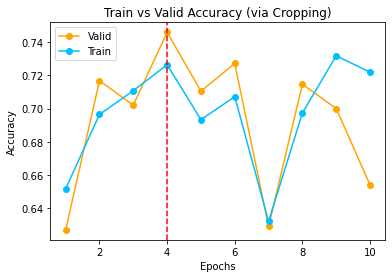

In [ ]:
plt.title("Train vs Valid Accuracy (via Cropping)")
plt.plot(epoch[0:10], test_accu_crop[0:10], marker='o', color='orange', label='Valid')
plt.plot(epoch[0:10], train_accu_crop[0:10], marker='o', color='deepskyblue', label='Train')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.axvline(x=test_accu_crop.index(max(test_accu_crop[0:10]))+1, color='r', linestyle='--')
plt.show()

In [ ]:
print(f'Train accuracy iteration: {train_accu_crop}')
print(f'Test accuracy iteration: {test_accu_crop}')

Train accuracy iteration: [0.6517857142857143, 0.6964285714285714, 0.7107142857142857, 0.7263392857142857, 0.6933035714285715, 0.7071428571428572, 0.6321428571428571, 0.6973214285714285, 0.7316964285714286, 0.721875, 0.7066964285714286, 0.7258928571428571, 0.7165178571428571, 0.6959821428571429, 0.7223214285714286, 0.7263392857142857, 0.775, 0.6611607142857143, 0.734375, 0.7205357142857143, 0.6919642857142857, 0.7379464285714286, 0.753125, 0.7388392857142857, 0.7526785714285714, 0.7620535714285714, 0.7375, 0.7620535714285714, 0.7473214285714286, 0.7816964285714286]
Test accuracy iteration: [0.6270833333333333, 0.7166666666666667, 0.7020833333333333, 0.7458333333333333, 0.7104166666666667, 0.7270833333333333, 0.6291666666666667, 0.7145833333333333, 0.7, 0.6541666666666667, 0.6583333333333333, 0.69375, 0.6791666666666667, 0.6958333333333333, 0.6708333333333333, 0.7041666666666667, 0.7333333333333333, 0.6083333333333333, 0.6770833333333334, 0.7020833333333333, 0.6479166666666667, 0.685416

## Color

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Net_Color.parameters(), lr=0.01, momentum=0.8, weight_decay = 0.02)

0 10 0.7557722210884095
0 20 0.6910372197628021
0 30 0.717012882232666
0 40 0.6360296964645386
0 50 0.6662367105484008
0 60 0.7174370110034942
0 70 0.6678194880485535
0 80 0.6363858699798584
0 90 0.6716529786586761
0 100 0.6429124355316163
0 110 0.7010327816009522
0 120 0.6270952075719833
0 130 0.5919542759656906
0 140 0.49660210609436034
0 150 0.570395341515541
0 160 0.689194792509079
0 170 0.6197498261928558
0 180 0.6308552622795105
0 190 0.6277239829301834
0 200 0.5800981491804122
0 210 0.5749570995569229
0 220 0.6747536361217499
0 230 0.6695734769105911
0 240 0.6197740852832794
0 250 0.5558694481849671
0 260 0.6382766127586365
0 270 0.5683738589286804
0 280 0.4987693428993225
1 10 0.5994429528713227
1 20 0.5100704342126846
1 30 0.665250164270401
1 40 0.6145856857299805
1 50 0.6758155703544617
1 60 0.6024151772260666
1 70 0.6006422489881516
1 80 0.5890610337257385
1 90 0.5978822559118271
1 100 0.5300243407487869
1 110 0.48810169398784636
1 120 0.5323993235826492
1 130 0.606960070133

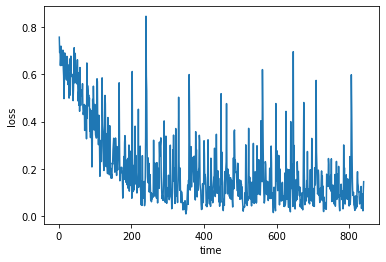

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
running_loss = 0 
printfreq = 10
l = []
t = []
k = 0
test_accu = []
train_accu = []
torch.manual_seed(1)
for epoch in range(30):
    for i, data in enumerate(Color_Train_Loader):
        inputs, labels = data
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        optimizer.zero_grad()
        outputs = Net_Color(inputs)  # forward pass 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % printfreq == printfreq-1:  
            print(epoch, i+1, running_loss / printfreq)
            k = k + 1
            l.append(running_loss / printfreq)
            t.append(k)
            running_loss = 0 

    total_test = 0  # keeps track of how many images we have processed 
    correct_test = 0  # keeps track of how many correct images our net predicts
    fname = './drive/MyDrive/dhz/images/Net_Color' + str(epoch) + '.pth'
    torch.save(Net_Color.state_dict(), fname)
    loaded_dict = torch.load(fname)
    Net_Color.load_state_dict(loaded_dict)
    with torch.no_grad():
      for i, data in enumerate(Animal_test_loader): 
        images, labels = data
        images = images.to('cuda')
        labels = labels.to('cuda')
        outputs = Net_Color(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size()[0]
        correct_test += (predicted == labels).sum().item()
        
    test_accu.append(correct_test/total_test)

    total_train = 0  # keeps track of how many images we have processed 
    correct_train = 0  # keeps track of how many correct images our net predicts
    with torch.no_grad():
      for i, data in enumerate(Color_Train_Loader): 
        images, labels = data
        images = images.to('cuda')
        labels = labels.to('cuda')
        outputs = Net_Color(images)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size()[0]
        correct_train += (predicted == labels).sum().item()
        
    train_accu.append(correct_train/total_train)
# plotting
l = np.array(l)
t = np.array(t)
plt.plot(t, l)
plt.xlabel("time")
plt.ylabel("loss")
plt.show()

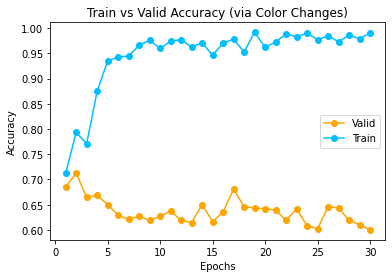

In [ ]:
epoch = range(1, len(test_accu) + 1)
test_accu_color = test_accu
train_accu_color = train_accu
plt.title("Train vs Valid Accuracy (via Color Changes)")
plt.plot(epoch, test_accu_color, marker='o', color='orange', label='Valid')
plt.plot(epoch, train_accu_color, marker='o', color='deepskyblue', label='Train')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

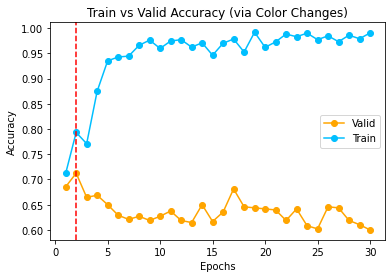

In [ ]:
plt.title("Train vs Valid Accuracy (via Color Changes)")
plt.plot(epoch, test_accu_color, marker='o', color='orange', label='Valid')
plt.plot(epoch, train_accu_color, marker='o', color='deepskyblue', label='Train')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.axvline(x=test_accu_color.index(max(test_accu_color))+1, color='r', linestyle='--')
plt.show()

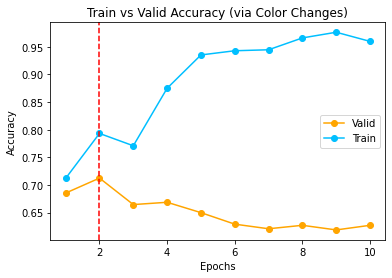

In [ ]:
plt.title("Train vs Valid Accuracy (via Color Changes)")
plt.plot(epoch[0:10], test_accu_color[0:10], marker='o', color='orange', label='Valid')
plt.plot(epoch[0:10], train_accu_color[0:10], marker='o', color='deepskyblue', label='Train')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.axvline(x=test_accu_color.index(max(test_accu_color[0:10]))+1, color='r', linestyle='--')
plt.show()

In [ ]:
print(f'Train accuracy iteration: {train_accu_color}')
print(f'Test accuracy iteration: {test_accu_color}')

Train accuracy iteration: [0.7120535714285714, 0.7933035714285714, 0.7709821428571428, 0.875, 0.9352678571428571, 0.9428571428571428, 0.9446428571428571, 0.9660714285714286, 0.9763392857142857, 0.9598214285714286, 0.9745535714285715, 0.9772321428571429, 0.9625, 0.9709821428571429, 0.9464285714285714, 0.9700892857142858, 0.9785714285714285, 0.9526785714285714, 0.9919642857142857, 0.9620535714285714, 0.9727678571428572, 0.9883928571428572, 0.9830357142857142, 0.9901785714285715, 0.9772321428571429, 0.9848214285714286, 0.9732142857142857, 0.9861607142857143, 0.9790178571428572, 0.990625]
Test accuracy iteration: [0.6854166666666667, 0.7125, 0.6645833333333333, 0.66875, 0.65, 0.6291666666666667, 0.6208333333333333, 0.6270833333333333, 0.61875, 0.6270833333333333, 0.6375, 0.61875, 0.6145833333333334, 0.65, 0.6166666666666667, 0.6354166666666666, 0.68125, 0.6458333333333334, 0.64375, 0.6416666666666667, 0.6395833333333333, 0.61875, 0.6416666666666667, 0.6083333333333333, 0.6020833333333333, 

## Blur

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Net_Blur.parameters(), lr=0.01, momentum=0.8, weight_decay = 0.02)

0 10 0.7943133175373077
0 20 0.6992700934410095
0 30 0.7143333733081818
0 40 0.6905054032802582
0 50 0.6653144538402558
0 60 0.6915869116783142
0 70 0.7032900631427765
0 80 0.6718212723731994
0 90 0.6453265190124512
0 100 0.5962926685810089
0 110 0.5914422154426575
0 120 0.6222711890935898
0 130 0.6339301079511642
0 140 0.5224229246377945
0 150 0.6308471858501434
0 160 0.7186625689268112
0 170 0.6253183007240295
0 180 0.5115609377622604
0 190 0.6266767472028733
0 200 0.6614021956920624
0 210 0.608780461549759
0 220 0.6013229191303253
0 230 0.6796941876411438
0 240 0.49002394676208494
0 250 0.4680645763874054
0 260 0.6888491421937942
0 270 0.5829079151153564
0 280 0.5904061138629914
1 10 0.528260225057602
1 20 0.5220697522163391
1 30 0.48339522182941436
1 40 0.6182282090187072
1 50 0.5250855177640915
1 60 0.4952043443918228
1 70 0.6128261178731919
1 80 0.5206468284130097
1 90 0.5305500477552414
1 100 0.5827767372131347
1 110 0.5583954244852066
1 120 0.5830383718013763
1 130 0.5507712572

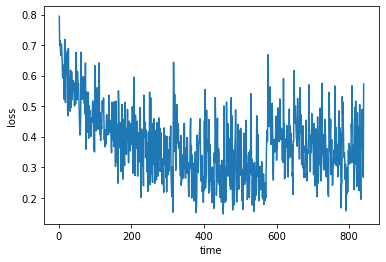

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
running_loss = 0 
printfreq = 10
l = []
t = []
k = 0
test_accu = []
train_accu = []
torch.manual_seed(1)
for epoch in range(30):
    for i, data in enumerate(Blur_Train_Loader):
        inputs, labels = data
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        optimizer.zero_grad()
        outputs = Net_Blur(inputs)  # forward pass 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % printfreq == printfreq-1:  
            print(epoch, i+1, running_loss / printfreq)
            k = k + 1
            l.append(running_loss / printfreq)
            t.append(k)
            running_loss = 0 

    total_test = 0  # keeps track of how many images we have processed 
    correct_test = 0  # keeps track of how many correct images our net predicts
    fname = './drive/MyDrive/dhz/images/Net_Blur' + str(epoch) + '.pth'
    torch.save(Net_Blur.state_dict(), fname)
    loaded_dict = torch.load(fname)
    Net_Blur.load_state_dict(loaded_dict)
    with torch.no_grad():
      for i, data in enumerate(Animal_test_loader): 
        images, labels = data
        images = images.to('cuda')
        labels = labels.to('cuda')
        outputs = Net_Blur(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size()[0]
        correct_test += (predicted == labels).sum().item()
        
    test_accu.append(correct_test/total_test)

    total_train = 0  # keeps track of how many images we have processed 
    correct_train = 0  # keeps track of how many correct images our net predicts
    with torch.no_grad():
      for i, data in enumerate(Blur_Train_Loader): 
        images, labels = data
        images = images.to('cuda')
        labels = labels.to('cuda')
        outputs = Net_Blur(images)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size()[0]
        correct_train += (predicted == labels).sum().item()
        
    train_accu.append(correct_train/total_train)
# plotting
l = np.array(l)
t = np.array(t)
plt.plot(t, l)
plt.xlabel("time")
plt.ylabel("loss")
plt.show()

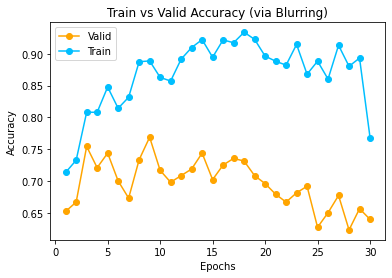

In [ ]:
epoch = range(1, len(test_accu) + 1)
test_accu_blur = test_accu
train_accu_blur = train_accu
plt.title("Train vs Valid Accuracy (via Blurring)")
plt.plot(epoch, test_accu_blur, marker='o', color='orange', label='Valid')
plt.plot(epoch, train_accu_blur, marker='o', color='deepskyblue', label='Train')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

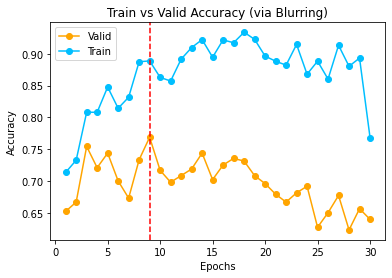

In [ ]:
plt.title("Train vs Valid Accuracy (via Blurring)")
plt.plot(epoch, test_accu_blur, marker='o', color='orange', label='Valid')
plt.plot(epoch, train_accu_blur, marker='o', color='deepskyblue', label='Train')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.axvline(x=test_accu_blur.index(max(test_accu_blur))+1, color='r', linestyle='--')
plt.show()

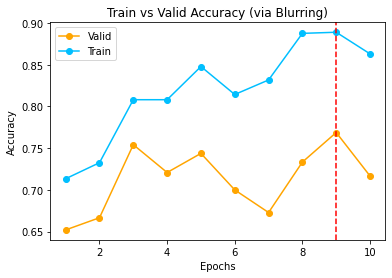

In [ ]:
plt.title("Train vs Valid Accuracy (via Blurring)")
plt.plot(epoch[0:10], test_accu_blur[0:10], marker='o', color='orange', label='Valid')
plt.plot(epoch[0:10], train_accu_blur[0:10], marker='o', color='deepskyblue', label='Train')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.axvline(x=test_accu_blur.index(max(test_accu_blur[0:10]))+1, color='r', linestyle='--')
plt.show()

In [ ]:
print(f'Train accuracy iteration: {train_accu_blur}')
print(f'Test accuracy iteration: {test_accu_blur}')

Train accuracy iteration: [0.7133928571428572, 0.7325892857142857, 0.8080357142857143, 0.8080357142857143, 0.8477678571428572, 0.8142857142857143, 0.8316964285714286, 0.8875, 0.8888392857142857, 0.8629464285714286, 0.8571428571428571, 0.8915178571428571, 0.9098214285714286, 0.9223214285714286, 0.8946428571428572, 0.921875, 0.9174107142857143, 0.9339285714285714, 0.9227678571428571, 0.8964285714285715, 0.8883928571428571, 0.8821428571428571, 0.9147321428571429, 0.8678571428571429, 0.8883928571428571, 0.8602678571428571, 0.9133928571428571, 0.8803571428571428, 0.8933035714285714, 0.7683035714285714]
Test accuracy iteration: [0.6520833333333333, 0.6666666666666666, 0.7541666666666667, 0.7208333333333333, 0.74375, 0.7, 0.6729166666666667, 0.7333333333333333, 0.76875, 0.7166666666666667, 0.6979166666666666, 0.7083333333333334, 0.71875, 0.74375, 0.7020833333333333, 0.725, 0.7354166666666667, 0.73125, 0.7083333333333334, 0.6958333333333333, 0.6791666666666667, 0.6666666666666666, 0.68125, 0.6

## Orignal

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Net_Orignal.parameters(), lr=0.01, momentum=0.8, weight_decay = 0.02)

0 10 0.7579619586467743
0 20 0.7221123456954956
0 30 0.677205714583397
0 40 0.6495394736528397
0 50 0.678572165966034
0 60 0.6919798761606216
0 70 0.6338270008563995
0 80 0.6884158432483674
0 90 0.661277973651886
0 100 0.6628827393054962
0 110 0.6589603841304779
0 120 0.6012512177228928
0 130 0.6894472777843476
0 140 0.599774706363678
1 10 0.6061969965696334
1 20 0.5376208424568176
1 30 0.5953722447156906
1 40 0.6814829170703888
1 50 0.6772830307483673
1 60 0.5732512503862381
1 70 0.5862963229417801
1 80 0.48712603747844696
1 90 0.6766295850276947
1 100 0.6097891747951507
1 110 0.7181076169013977
1 120 0.6300274670124054
1 130 0.5603464007377624
1 140 0.4667318880558014
2 10 0.41168513894081116
2 20 0.7121594816446304
2 30 0.6034722030162811
2 40 0.6724882692098617
2 50 0.6016548335552215
2 60 0.5992829233407975
2 70 0.5398836672306061
2 80 0.35968250781297684
2 90 0.6297222524881363
2 100 0.6257652193307877
2 110 0.5142254024744034
2 120 0.5479479268193245
2 130 0.5215395599603653
2 1

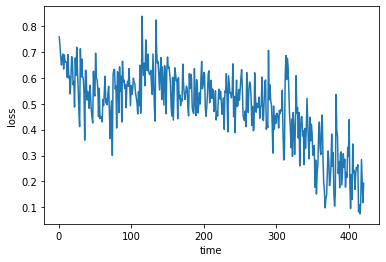

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
running_loss = 0 
printfreq = 10
l = []
t = []
k = 0
test_accu = []
train_accu = []
torch.manual_seed(1)
for epoch in range(30):
    for i, data in enumerate(Orignal_Train_Loader):
        inputs, labels = data
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        optimizer.zero_grad()
        outputs = Net_Orignal(inputs)  # forward pass 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % printfreq == printfreq-1:  
            print(epoch, i+1, running_loss / printfreq)
            k = k + 1
            l.append(running_loss / printfreq)
            t.append(k)
            running_loss = 0 

    total_test = 0  # keeps track of how many images we have processed 
    correct_test = 0  # keeps track of how many correct images our net predicts
    fname = './drive/MyDrive/dhz/images/Net_Orignal' + str(epoch) + '.pth'
    torch.save(Net_Orignal.state_dict(), fname)
    loaded_dict = torch.load(fname)
    Net_Orignal.load_state_dict(loaded_dict)
    with torch.no_grad():
      for i, data in enumerate(Animal_test_loader): 
        images, labels = data
        images = images.to('cuda')
        labels = labels.to('cuda')
        outputs = Net_Orignal(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size()[0]
        correct_test += (predicted == labels).sum().item()
        
    test_accu.append(correct_test/total_test)

    total_train = 0  # keeps track of how many images we have processed 
    correct_train = 0  # keeps track of how many correct images our net predicts
    with torch.no_grad():
      for i, data in enumerate(Orignal_Train_Loader): 
        images, labels = data
        images = images.to('cuda')
        labels = labels.to('cuda')
        outputs = Net_Orignal(images)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size()[0]
        correct_train += (predicted == labels).sum().item()
        
    train_accu.append(correct_train/total_train)
# plotting
l = np.array(l)
t = np.array(t)
plt.plot(t, l)
plt.xlabel("time")
plt.ylabel("loss")
plt.show()

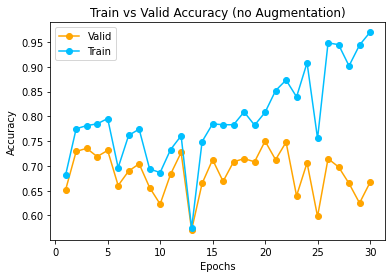

In [ ]:
epoch = range(1, len(test_accu) + 1)
test_accu_orignal = test_accu
train_accu_orignal = train_accu
plt.title("Train vs Valid Accuracy (no Augmentation)")
plt.plot(epoch, test_accu_orignal, marker='o', color='orange', label='Valid')
plt.plot(epoch, train_accu_orignal, marker='o', color='deepskyblue', label='Train')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

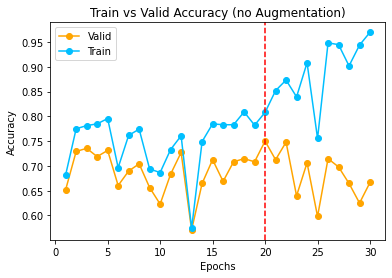

In [ ]:
plt.title("Train vs Valid Accuracy (no Augmentation)")
plt.plot(epoch, test_accu_orignal, marker='o', color='orange', label='Valid')
plt.plot(epoch, train_accu_orignal, marker='o', color='deepskyblue', label='Train')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.axvline(x=test_accu_orignal.index(max(test_accu_orignal))+1, color='r', linestyle='--')
plt.show()

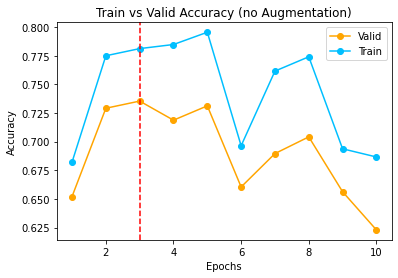

In [ ]:
plt.title("Train vs Valid Accuracy (no Augmentation)")
plt.plot(epoch[0:10], test_accu_orignal[0:10], marker='o', color='orange', label='Valid')
plt.plot(epoch[0:10], train_accu_orignal[0:10], marker='o', color='deepskyblue', label='Train')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.axvline(x=test_accu_orignal.index(max(test_accu_orignal[0:10]))+1, color='r', linestyle='--')
plt.show()

In [ ]:
print(f'Train accuracy iteration: {train_accu_orignal}')
print(f'Test accuracy iteration: {test_accu_orignal}')

Train accuracy iteration: [0.6821428571428572, 0.775, 0.78125, 0.7848214285714286, 0.7955357142857142, 0.6964285714285714, 0.7616071428571428, 0.7741071428571429, 0.69375, 0.6866071428571429, 0.7330357142857142, 0.7607142857142857, 0.5741071428571428, 0.7491071428571429, 0.7848214285714286, 0.7830357142857143, 0.7830357142857143, 0.8089285714285714, 0.7821428571428571, 0.8080357142857143, 0.8517857142857143, 0.8732142857142857, 0.8392857142857143, 0.9080357142857143, 0.7553571428571428, 0.9482142857142857, 0.9446428571428571, 0.9017857142857143, 0.94375, 0.9696428571428571]
Test accuracy iteration: [0.6520833333333333, 0.7291666666666666, 0.7354166666666667, 0.71875, 0.73125, 0.6604166666666667, 0.6895833333333333, 0.7041666666666667, 0.65625, 0.6229166666666667, 0.6833333333333333, 0.7270833333333333, 0.5708333333333333, 0.6645833333333333, 0.7125, 0.66875, 0.7083333333333334, 0.7145833333333333, 0.7083333333333334, 0.75, 0.7125, 0.7479166666666667, 0.6395833333333333, 0.70625, 0.5979